In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import matplotlib.pyplot as plt
import pickle




In [2]:
# overview the training data
x_train_df = pd.read_csv(os.path.join('data_reviews', 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join('data_reviews', 'y_train.csv'))

tr_text_list = x_train_df.values.tolist()
tr_y_list = y_train_df.values.tolist()

tr_y = np.hstack(np.array(tr_y_list))


In [3]:
vectorizer = CountVectorizer(strip_accents='ascii', lowercase=True, max_df=0.9)
reviews_list = [val[1] for val in tr_text_list]
vectorizer = vectorizer.fit(reviews_list)

print("Size of Vocab:", len(vectorizer.get_feature_names_out()))

Size of Vocab: 4512


In [4]:
with open('vectorizer1.pkl','wb') as f:
    pickle.dump(vectorizer,f)

In [5]:
def extract_BoW_features(data_list):
    with open('vectorizer1.pkl','rb') as f:
        vectorizer = pickle.load(f)
    reviews_list = [val[1] for val in data_list]
    features_count = vectorizer.transform(reviews_list)
    return features_count

features_count = extract_BoW_features(tr_text_list)

In [6]:
param_grid = {
    'C' : np.logspace(-9, 6, 31),
    'penalty': ['l1', 'l2']
}

In [7]:
lr = sklearn.linear_model.LogisticRegression(solver='liblinear')
# Setup GridSearchCV with AUROC scoring
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)
grid_search = GridSearchCV(lr, param_grid, scoring=auroc_scorer, cv=5, refit=True, return_train_score=True)

grid_search.fit(features_count, tr_y)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-09, 3.16227766e-09, 1.00000000e-08, 3.16227766e-08,
       1.00000000e-07, 3.16227766e-07, 1.00000000e-06, 3.16227766e-06,
       1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True,
             scoring=make_scorer(roc_auc_score, needs_proba=True))

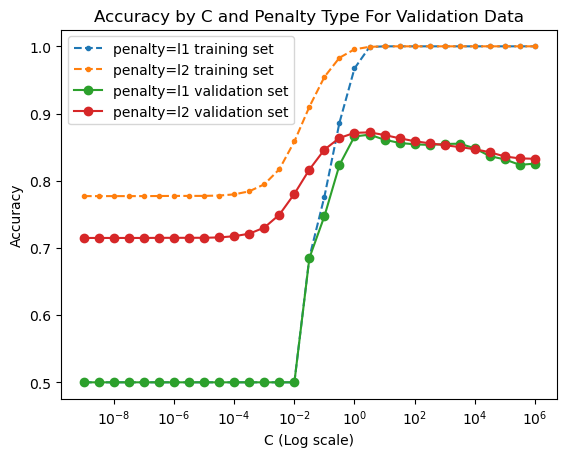

In [18]:
grid_search.cv_results_
results_df_train = pd.concat([
    pd.DataFrame(grid_search.cv_results_["params"]),
    pd.DataFrame(grid_search.cv_results_["mean_train_score"], columns=["Accuracy"])
], axis=1)

results_df_test = pd.concat([
    pd.DataFrame(grid_search.cv_results_["params"]),
    pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])
], axis=1)

fig, ax = plt.subplots()

for penalty in results_df_train['penalty'].unique():
    subset = results_df_train[results_df_train['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='.', linestyle='dashed', label=f'penalty={penalty} training set')

# Loop through each unique penalty type in your results to create a separate line in the plot
for penalty in results_df_test['penalty'].unique():
    subset = results_df_test[results_df_test['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='o', label=f'penalty={penalty} validation set')

# Set the x-axis to a logarithmic scale to better visualize the wide range of C values
ax.set_xscale('log')
# Label your axes and create a title
ax.set_xlabel('C (Log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by C and Penalty Type First CV')
# Display a legend to differentiate between penalty types
ax.legend()

# Show the plot
plt.show()

In [9]:
cv_results = grid_search.cv_results_
cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

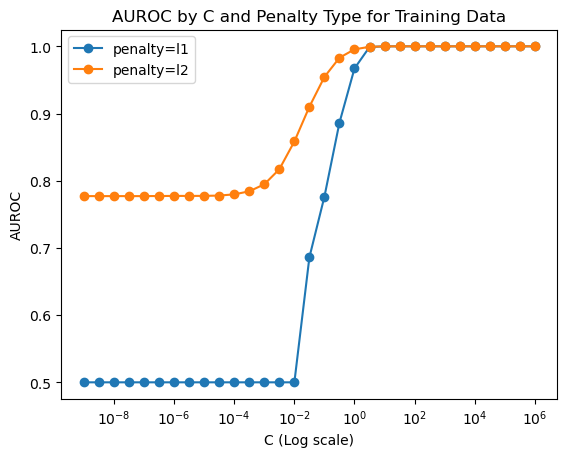

In [23]:


results_df = pd.concat([
    pd.DataFrame(grid_search.cv_results_["params"]),
    pd.DataFrame(grid_search.cv_results_["mean_train_score"], columns=["Accuracy"])
], axis=1)

fig, ax = plt.subplots()

# Loop through each unique penalty type in your results to create a separate line in the plot
for penalty in results_df['penalty'].unique():
    subset = results_df[results_df['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='o', label=f'penalty={penalty}')

# Set the x-axis to a logarithmic scale to better visualize the wide range of C values
ax.set_xscale('log')
# Label your axes and create a title
ax.set_xlabel('C (Log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by C and Penalty Type for Training Data')
# Display a legend to differentiate between penalty types
ax.legend()

# Show the plot
plt.show()

In [11]:
print("Best parameters:", grid_search.best_params_)
print("Best AUROC score:", grid_search.best_score_)

# best seen AUROC: 0.8723802083333334

Best parameters: {'C': 3.1622776601683795, 'penalty': 'l2'}
Best AUROC score: 0.87196875


In [26]:
best_C = grid_search.best_params_['C']
new_param_grid = {
    'C' : np.logspace(-1 * best_C, best_C, 51),
    'penalty': ['l1', 'l2']
}
# print(new_param_grid)
new_grid_search = GridSearchCV(lr, new_param_grid, scoring=auroc_scorer, cv=10, refit=True, return_train_score=True)
new_grid_search.fit(features_count, tr_y)



GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([6.88212157e-04, 9.20902064e-04, 1.23226625e-03, 1.64890509e-03,
       2.20641279e-03, 2.95241819e-03, 3.95065384e-03, 5.28640077e-03,
       7.07377417e-03, 9.46547249e-03, 1.26658227e-02, 1.69482363e-02,
       2.26785674e-02, 3.03463682e-02, 4.06067124e-02, 5.43361591e-02,
       7.27076390e-02, 9.729...
       7.68135337e+00, 1.02784790e+01, 1.37537130e+01, 1.84039508e+01,
       2.46264704e+01, 3.29528724e+01, 4.40944960e+01, 5.90031896e+01,
       7.89526290e+01, 1.05647130e+02, 1.41367250e+02, 1.89164621e+02,
       2.53122658e+02, 3.38705406e+02, 4.53224350e+02, 6.06463043e+02,
       8.11512936e+02, 1.08589180e+03, 1.45304030e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True,
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [ ]:
new_grid_search.cv_results_
results_df_train = pd.concat([
    pd.DataFrame(new_grid_search.cv_results_["params"]),
    pd.DataFrame(new_grid_search.cv_results_["mean_train_score"], columns=["Accuracy"])
], axis=1)

results_df_test = pd.concat([
    pd.DataFrame(new_grid_search.cv_results_["params"]),
    pd.DataFrame(new_grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])
], axis=1)

fig, ax = plt.subplots()

for penalty in results_df_train['penalty'].unique():
    subset = results_df_train[results_df_train['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='.', linestyle='dashed', label=f'penalty={penalty} training set')

# Loop through each unique penalty type in your results to create a separate line in the plot
for penalty in results_df_test['penalty'].unique():
    subset = results_df_test[results_df_test['penalty'] == penalty]
    ax.plot(subset['C'], subset['Accuracy'], marker='o', label=f'penalty={penalty} validation set')

# Set the x-axis to a logarithmic scale to better visualize the wide range of C values
ax.set_xscale('log')
# Label your axes and create a title
ax.set_xlabel('C (Log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by C and Penalty Type Second CV')
# Display a legend to differentiate between penalty types
ax.legend()

# Show the plot
plt.show()



In [13]:

best_model = new_grid_search.best_estimator_

with open('classifier1.pkl','wb') as f:
    pickle.dump(best_model,f)